In [65]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from numpy import clip
from torch.autograd import Variable
import torch
from torch import Tensor
from torch.optim import SGD
from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import interact
w = widgets.IntText()
%matplotlib inline
%run utils.py

In [66]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [67]:
M, N = (40,140) 

In [58]:
%%cython
import numpy as np
cimport numpy as np

cdef int M, N
M, N = (40,140)

def min_cost(tuple source, tuple target, np.ndarray[float, ndim=2] w):
    cdef int sx, sy, tx, ty, i, j
    sx, sy = source
    tx, ty = target

    cdef int hor_dir, ver_dir
    hor_dir = np.sign(tx - sx)
    ver_dir = np.sign(ty - sy)

    cdef int X, Y
    cdef np.ndarray[double, ndim=2] cost
    cdef np.ndarray[list, ndim=2] paths

    X = np.abs(tx - sx) + 1
    Y = np.abs(ty - sy) + 1
    cost = np.zeros((X, Y))
    paths = np.zeros((X, Y), dtype=object)

    cost[0, 0] = w[sx, sy]
    paths[0, 0] = [source]

    for i in range(1, X):
        cost[i, 0] = cost[i - 1, 0] + w[i * hor_dir + sx, sy]
        paths[i, 0] = paths[i - 1, 0] + [(i * hor_dir + sx, sy)]

    for j in range(1, Y):
        cost[0, j] = cost[0, j - 1] + w[sx, sy + j * ver_dir]
        paths[0, j] = paths[0, j - 1] + [(sx, sy + j * ver_dir)]

    for i in range(1, X):
        for j in range(1, Y):
            if cost[i, j - 1] <= cost[i - 1, j]:
                cost[i, j] = cost[i, j - 1] + \
                    w[sx + i * hor_dir, sy + j * ver_dir]
                paths[i, j] = paths[i, j - 1] + \
                    [(sx + i * hor_dir, sy + j * ver_dir)]
            else:
                cost[i - 1, j] = cost[i - 1, j] + \
                    w[sx + i * hor_dir, sy + j * ver_dir]
                paths[i, j] = paths[i - 1, j] + \
                    [(sx + i * hor_dir, sy + j * ver_dir)]

    cdef np.ndarray st
    st = np.zeros((M,N))

    for i, j in paths[X-1,Y-1]:
        st[i,j] = 1
    return st



In [61]:
def random_path(source, target):
    sx, sy = source
    tx, ty = target
    hor_dir = np.sign(tx - sx)
    ver_dir = np.sign(ty - sy)
    X = np.abs(tx - sx) 
    Y = np.abs(ty - sy) 
    path = np.zeros(X+Y)
    path[:X] = 1
    path = np.random.permutation(path)
    st = np.zeros((M,N))
    st[sx, sy] = 1
    lastx, lasty = sx, sy
    
    for i in path:
        if i == 0:
            lasty += ver_dir
            st[lastx, lasty] = 1
        else:
            lastx += hor_dir
            st[lastx, lasty] = 1
    return st

In [88]:
# %run utils.py
# chunks = pd.read_csv('data/yellow_tripdata_2009-01_train.csv', chunksize=100000)

# h = True
# for df in tqdm(chunks, total=93):
#     df = rotate_manhattan(filter_manhattan(unnormalize(df)))
#     df.to_csv('data/yellow_tripdata_2009-01_train_JC.csv', mode='a',
#               index=False,
#               header=h)
#     h = False

A Jupyter Widget

/Users/jiafengchen/Documents/Junior/CS 281/final-project/utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['start_x'] = (starts[:, 0] + 84.125113) / 0.005
/Users/jiafengchen/Documents/Junior/CS 281/final-project/utils.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['start_y'] = (starts[:, 1] + 7.853407) / 0.005
/Users/jiafengchen/Documents/Junior/CS 281/final-project/utils.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [21]:
# chunks = pd.read_csv('data/yellow_tripdata_2009-01_train_JC.csv', chunksize=1000)

In [22]:
# grid = np.load('grid.npy')
# gr = np.zeros((20,70))
# for i, j in grid:
#     gr[int(i), int(j)] = 1.0

weights = Variable((15 * torch.ones((M,N))).float(), requires_grad=True)
optimizer = SGD([weights], lr = 0.0001)

In [24]:
@interact(x=w)
def plot(x):
    plt.figure(figsize=(10,10))
    plt.imshow(torch.nn.functional.softplus(weights).data.numpy().T, 
               clim=(0,50), cmap='bwr', origin='lower')
    plt.savefig('{}.png'.format(x))
    plt.show()
    

In [25]:
optimizer = SGD([weights], lr = 0.001)
num_epochs = 5
with tqdm(total=num_epochs * 8030 * 1000) as pbar:
    for epoch in range(num_epochs):
        chunks = pd.read_csv('data/yellow_tripdata_2009-01_train_JC.csv', 
                             chunksize=10000)
        total_loss, n = 0, 0
        for df in chunks:
            for _, row in df.iterrows():
                pbar.update(1)
                source = (int(clip(round(M/10 * row['start_x']), 0, M-1)), 
                          int(clip(round(M/10 * row['start_y']), 0, N-1)))
                target = (int(clip(round(M/10 * row['end_x']), 0, M-1)), 
                          int(clip(round(M/10 * row['end_y']), 0, N-1)))
                if np.random.rand() < 0.5:
                    path = min_cost(source, target, 
                                    torch.nn.functional.softplus(weights).data.numpy())
                else:
                    path = random_path(source, target)
                pred = (Variable(Tensor(path)) 
                        * torch.nn.functional.softplus(weights)).sum()
                loss = (pred - row['duration']) ** 2
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += np.sqrt(loss.data[0])
                n += 1
                if pbar.n % 2000 == 0:
                    print(total_loss/n/60)
                    w.value += 1
                    clear_output(wait=True)

KeyboardInterrupt: 

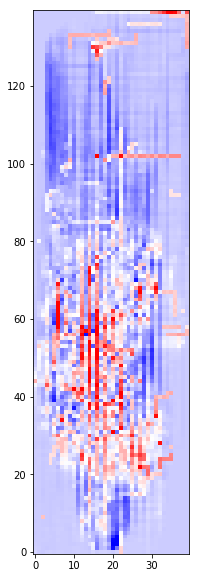

In [421]:
plt.figure(figsize=(10,10))
plt.imshow(torch.nn.functional.softplus(torch.load('weights_4x_min_cost.pt')).data.numpy().T, 
           clim=(0,50), cmap='bwr', origin='lower')
plt.show()

In [417]:
torch.save(weights, 'weights_4x_min_cost.pt')

In [ ]:
torch.nn.functional.softplus()

In [282]:
torch.save(weights, 'weights_min_cost_route.fyre')

In [348]:
torch.nn.functional.relu(torch.arange(-3,3))

Variable containing:
 0
 0
 0
 0
 1
 2
[torch.FloatTensor of size 6]

In [131]:
cs = pd.read_csv('data/yellow_tripdata_2009-01_train_JC.csv', chunksize=100000)

In [132]:
t = next(cs)

In [146]:
w = weights.data.numpy().copy()


In [157]:
w = weights.data.numpy().copy()
w[(w > 700)] = np.nan

(array([   2.,    0.,    3.,   12.,    9.,   37.,   75.,  139.,   20.,    1.]),
 array([-290.10040283, -240.25682678, -190.41325073, -140.56967468,
         -90.72609863,  -40.88252258,    8.96105347,   58.80462952,
         108.64820557,  158.49178162,  208.33535767]),
 <a list of 10 Patch objects>)

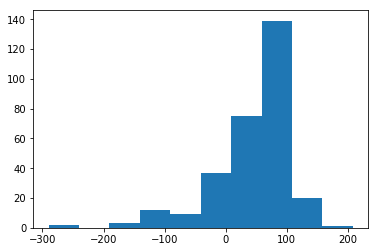

In [158]:
plt.hist((w[~np.isnan(w)]))

In [343]:
Tensor(w)



Columns 0 to 7 
      nan       nan       nan       nan       nan       nan       nan       nan
      nan       nan       nan       nan       nan       nan    1.2149  119.3661
  28.4302   27.2659   25.6951  -46.5341  -76.7424  290.5429   88.2641   86.9757
 158.9543   57.4560   84.4407   77.9714   60.1472   48.4417  103.5183   92.4683
  92.5302  103.2559   71.5246   70.1352   65.4769   92.2900   65.6773  101.5462
 -52.9651   61.4082   64.1475   74.4736   93.0974   93.3437   97.0056   79.4190
  87.6263   49.4165   75.8425   12.3904   84.2782  111.3638  110.7038   89.3369
  71.6831  -31.6727       nan   87.6937   72.8622   99.2550  112.5938   75.7369
      nan       nan       nan  -59.6603   46.6569   85.6310   52.6893  121.0769
      nan       nan       nan       nan  -30.4932   21.3744   82.2779   52.6452

Columns 8 to 15 
  66.2011   79.7420  123.9766   88.2895   65.5448  134.9269   48.3167   84.0836
 133.7874   80.9889   -6.5578  129.8626   72.5021   58.5735   67.9946   55.9030
  68

AttributeError: 'AxesSubplot' object has no attribute 'colorbar'

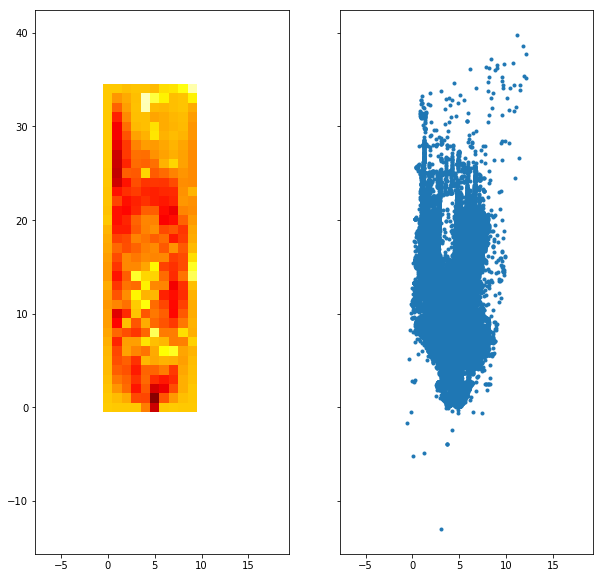

In [367]:
w = torch.nn.functional.softplus(weights).data.numpy().copy()
w[(w > 400)|(w<-100)] = np.nan
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax1.imshow(w.T,origin='lower', clim=(0,150), cmap='hot')
ax2.plot(t['start_x'], t['start_y'], '.')
ax2.axis('equal')
ax1.colorbar()

(-1.2025609488574673,
 12.767860741294614,
 -15.658745946636046,
 42.421876456482572)

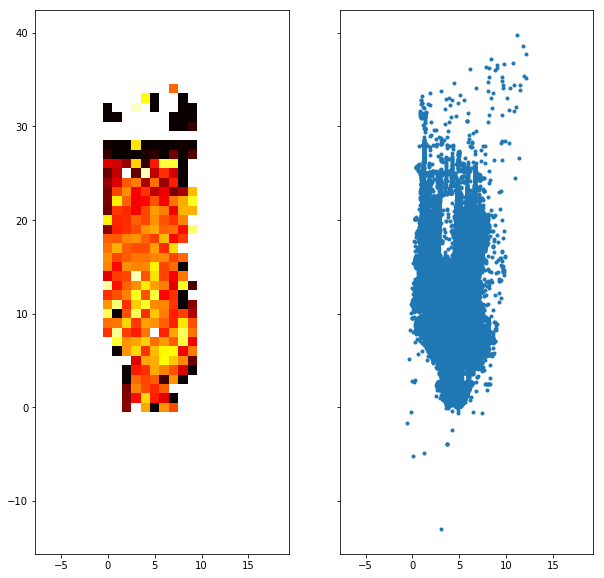

In [341]:

w = torch.load('weights_min_cost_route.fyre').data.numpy().copy()
w[(w > 400)|(w<-100)] = np.nan
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax1.imshow(w.T,origin='lower', clim=(0,150),cmap='hot')
ax2.plot(t['start_x'], t['start_y'], '.')
ax2.axis('equal')


In [164]:
chunks = pd.read_csv('data/yellow_tripdata_2009-01_test.csv', chunksize=100000)

h = True
for df in tqdm(chunks, total=93):
    df = rotate_manhattan(filter_manhattan(unnormalize(df)))
    df.to_csv('data/yellow_tripdata_2009-01_test_JC.csv', mode='a',
              index=False,
              header=h)
    h = False

/Users/jiafengchen/Documents/Junior/CS 281/final-project/utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['start_x'] = (starts[:, 0] + 84.125113) / 0.005
/Users/jiafengchen/Documents/Junior/CS 281/final-project/utils.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['start_y'] = (starts[:, 1] + 7.853407) / 0.005
/Users/jiafengchen/Documents/Junior/CS 281/final-project/utils.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [167]:

chunks = pd.read_csv('data/yellow_tripdata_2009-01_test_JC.csv', 
                     chunksize=1000)
losses = []
for df in tqdm(chunks):
    for i, row in df.iterrows():
        pbar.update(1)
        source = (int(clip(round(row['start_x']), 0, 9)), 
                  int(clip(round(row['start_y']), 0, 34)))
        target = (int(clip(round(row['end_x']), 0, 9)), 
                  int(clip(round(row['end_y']), 0, 34)))
        path = min_cost(source, target, weights.data.numpy())
        pred = (Variable(Tensor(path)) * weights).sum()
        loss = (pred - row['duration']) ** 2
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        losses.append(loss.data[0])
        if i % 50 == 0:
            print(np.sqrt(loss.data[0])/60)
            clear_output(wait=True)

In [175]:
losses = np.array(losses)


In [179]:
minute_loss = np.sqrt(losses)/60

In [190]:
np.percentile(minute_loss, 99)

15.493657230987296

In [195]:
minute_loss.mean()

3.2759178529053168

In [185]:
test = pd.read_csv('data/yellow_tripdata_2009-01_test_JC.csv')

In [194]:
np.percentile(test['duration'],99.99)/60

1142.0

In [187]:
86340.0/60

1439.0

In [87]:
next(chunks)

,duration,Trip_Distance,Start_Lon,Start_Lat,End_Lon,End_Lat,week_0,week_1,week_2,week_3,...,hour_22,hour_23,start_lon_raw,start_lat_raw,end_lon_raw,end_lat_raw,start_x,start_y,end_x,end_y
429000,220.0,-0.593514,0.432520,2.163505,0.726924,2.266675,0,0,0,0,...,0,1,-73.967914,40.802162,-73.957464,40.811673,1.118189,21.814597,1.780374,24.561955
429001,1416.0,0.227681,0.140130,0.088084,-1.229397,-0.220854,1,0,0,0,...,0,0,-73.974909,40.755201,-74.008307,40.747443,5.231644,13.255969,0.574109,8.222889
429002,690.0,-0.182917,0.960200,0.671054,-0.118238,0.331298,1,0,0,0,...,0,0,-73.955290,40.768392,-73.979429,40.761700,6.998494,17.641689,3.753942,13.824380
429003,976.0,0.455790,-0.159783,0.090780,1.278270,0.938482,1,0,0,0,...,0,0,-73.982084,40.755262,-73.943135,40.777378,4.037120,12.460678,8.001837,20.493529
429004,754.0,0.866388,1.050404,1.002249,-0.605827,-1.125745,0,0,1,0,...,1,0,-73.953132,40.775886,-73.992101,40.724078,6.514511,19.124404,5.879388,6.174396
429005,450.0,-0.365404,-1.068510,-0.423866,-0.449724,0.245398,0,1,0,0,...,0,0,-74.003824,40.743617,-73.988044,40.759482,1.745645,8.092785,2.576871,12.490208
429006,288.0,-0.821624,-0.202377,-1.169119,-0.167528,-1.060991,0,1,0,0,...,0,0,-73.983103,40.726754,-73.980710,40.725750,7.068446,7.627372,7.577257,7.729793
429007,1513.0,0.638278,-0.312603,0.423963,-0.676319,-1.249947,0,0,0,0,...,0,0,-73.985740,40.762801,-73.993933,40.720871,2.585697,13.298224,5.936121,5.437902
429008,242.0,-0.730380,-0.839615,-1.263430,-0.901451,-0.760187,0,0,1,0,...,0,0,-73.998348,40.724620,-73.999784,40.733517,4.784484,5.562892,3.548102,6.874421
429009,208.0,-0.228539,0.375630,0.205023,0.921005,1.092932,0,0,0,1,...,0,0,-73.969275,40.757847,-73.952420,40.781366,5.867227,14.326372,6.017243,20.111428


In [80]:
g = np.zeros((10,35))

In [81]:
g[grid]

IndexError: arrays used as indices must be of integer (or boolean) type

In [78]:
grid

array([[  2.,   0.],
       [  3.,   0.],
       [  4.,   0.],
       [  5.,   0.],
       [  6.,   0.],
       [  7.,   0.],
       [  2.,   1.],
       [  3.,   1.],
       [  4.,   1.],
       [  5.,   1.],
       [  6.,   1.],
       [  7.,   1.],
       [  2.,   2.],
       [  3.,   2.],
       [  4.,   2.],
       [  5.,   2.],
       [  6.,   2.],
       [  7.,   2.],
       [  2.,   3.],
       [  3.,   3.],
       [  4.,   3.],
       [  5.,   3.],
       [  6.,   3.],
       [  7.,   3.],
       [  8.,   3.],
       [  2.,   4.],
       [  3.,   4.],
       [  4.,   4.],
       [  5.,   4.],
       [  6.,   4.],
       [  7.,   4.],
       [  8.,   4.],
       [  9.,   4.],
       [  1.,   5.],
       [  2.,   5.],
       [  3.,   5.],
       [  4.,   5.],
       [  5.,   5.],
       [  6.,   5.],
       [  7.,   5.],
       [  8.,   5.],
       [  9.,   5.],
       [  1.,   6.],
       [  2.,   6.],
       [  3.,   6.],
       [  4.,   6.],
       [  5.,   6.],
       [  6.,

In [85]:
500 - gr * 500

array([[ 500.,  500.,  500.,  500.,  500.,  500.,  500.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  500.,  500.,    0.,    0.,  500.,  500.],
       [ 500.,  500.,  500.,  500.,  500.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  500.,    0.,    0.,    0.,  500.,  500.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  500.,    0.,    0.,    0.,  500.,  500.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,   

(-0.5736560024074322,
 11.761119367576924,
 -2.9819052614255535,
 35.76104310768693)

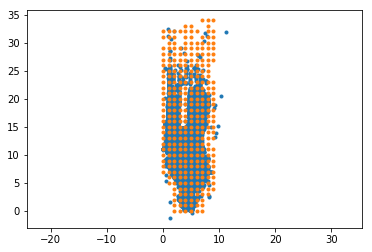

In [45]:
plt.plot(df['start_x']/0.005, df['start_y']/0.005,'.')
plt.plot(grid[:,0]/0.005,grid[:,1]/0.005,'.')
plt.axis('equal')

In [2]:
weight = np.arange(350).reshape(10, 35)